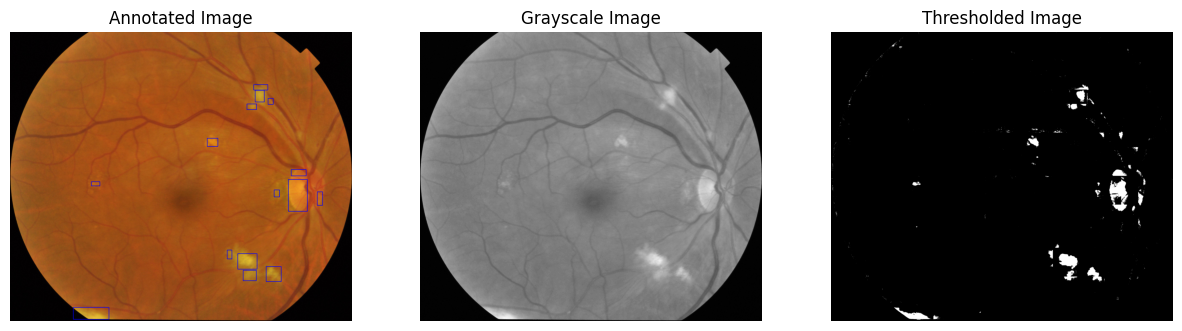

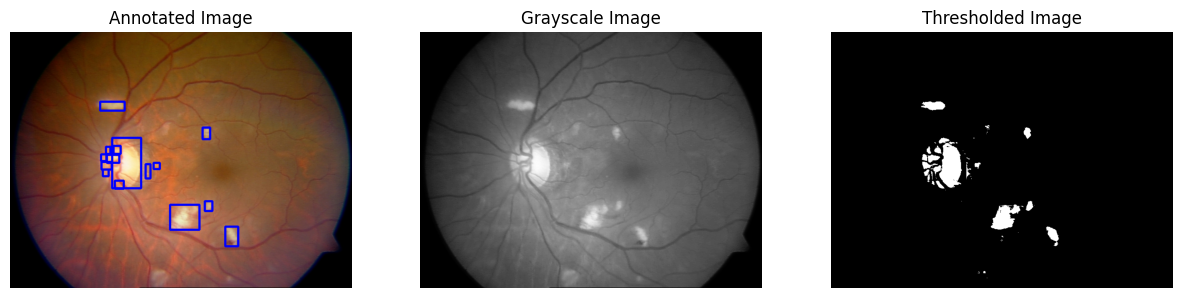

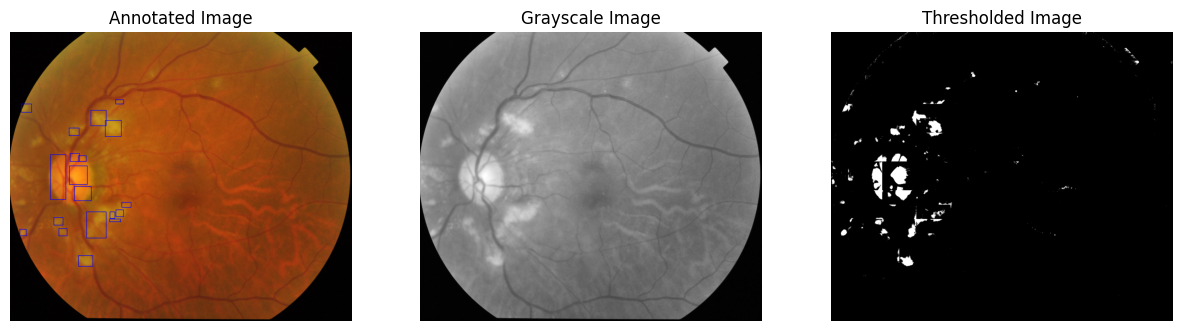

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define image paths and output folder
image_paths = ["1.JPG", "2.JPG", "3.JPG"]
output_folder = "./annotated_images4"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def annotate_image(image_path, grid_size=(20, 20)):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Replace the black background with nearest non-background pixels using TELEA inpainting
    background_mask = (gray <= 80).astype(np.uint8)
    inpainted_image = cv2.inpaint(gray, background_mask, inpaintRadius=7, flags=cv2.INPAINT_TELEA)
    
    # Detect the fundus boundary
    _, fundus_mask = cv2.threshold(inpainted_image, 80, 255, cv2.THRESH_BINARY)
    fundus_mask = cv2.morphologyEx(fundus_mask, cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    
    height, width = gray.shape
    region_height = height // grid_size[0]
    region_width = width // grid_size[1]
    thresh = np.zeros_like(gray)
    
    # i Applied CLAHE and process each region ((Contrast Limited Adaptive Histogram Equalization): Enhances contrast in each region to detect anomalies better)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    for i in range(grid_size[0]):
        for j in range(grid_size[1]):
            y_start, y_end = i * region_height, (i + 1) * region_height
            x_start, x_end = j * region_width, (j + 1) * region_width
            
            # Extract and enhance the region
            region = inpainted_image[y_start:y_end, x_start:x_end]
            enhanced_region = clahe.apply(region)
            
            # Calculate the local threshold
            local_threshold = np.mean(enhanced_region) + 10
            _, region_thresh = cv2.threshold(region, local_threshold, 255, cv2.THRESH_BINARY)
            
            thresh[y_start:y_end, x_start:x_end] = region_thresh
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours to exclude those near the boundary
    valid_contours = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if cv2.countNonZero(fundus_mask[y:y+h, x:x+w]) > 0.99 * w * h:  # Keep if 99% of the contour is within the fundus
            valid_contours.append(contour)
    
    # Draw valid contours
    for contour in valid_contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w * h < (height*width) / 3300:  # Exclude small regions
            continue
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 3)
    
    return img, gray, thresh

for image_path in image_paths:
    annotated_img, gray_img, thresh_img = annotate_image(image_path)
    
    output_path = f"{output_folder}/{image_path.split('/')[-1]}"
    cv2.imwrite(output_path, annotated_img)
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
    plt.title("Annotated Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(gray_img, cmap="gray")
    plt.title("Grayscale Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(thresh_img, cmap="gray")
    plt.title("Thresholded Image")
    plt.axis("off")
    
    plt.show()
